In [55]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [51]:
#model = load_model('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
model = ResNet50(weights='imagenet', include_top=False)
model.save('./resnet50_model.h5')

In [20]:
target_path = "../image/dataset/miml_data.mat"
y = sio.loadmat(target_path)
y = y['targets']
y = y.transpose()
y = np.array([[elem if elem == 1 else 0 for elem in row]for row in y])
print(y.shape)

(2000, 5)


In [21]:
file_path = "../image/dataset/original"
x = []
for i in range(1, 2001):
    img_path = file_path + "/" + str(i) + ".jpg"
    img = image.load_img(img_path, target_size=(200, 200))
    img = image.img_to_array(img)
    x.append(img)
x = np.array(x)
x = preprocess_input(x)
print(x.shape)

(2000, 200, 200, 3)


In [22]:
# feature extraction
x = model.predict(x)
print(x.shape)

(2000, 1, 1, 2048)


In [23]:
x = x.reshape(x.shape[0], 2048)
print(x.shape)

(2000, 2048)


In [26]:
permutation = list(np.random.permutation(x.shape[0]))
x = x[permutation,:]
y = y[permutation,:]
print('x.shape: ', x.shape)
print('y.shape: ', y.shape)

x.shape:  (2000, 2048)
y.shape:  (2000, 5)


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss
from mllearn.problem_transform import BinaryRelevance
from mllearn.problem_transform import CalibratedLabelRanking
from mllearn.problem_transform import ClassifierChain
from mllearn.problem_transform import RandomKLabelsets
from mllearn.alg_adapt import MLKNN

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [32]:
classif_br = BinaryRelevance()
classif_br.fit(X_train, y_train)
predictions = classif_br.predict(X_test)
print('The BinaryRelevance is %f' % hamming_loss(y_test, predictions))

The BinaryRelevance is 0.076667


In [33]:
classif_cc = ClassifierChain()
classif_cc.fit(X_train, y_train)
predictions = classif_cc.predict(X_test)
print('The Classifier Chain Result is %f' % hamming_loss(y_test, predictions))

The Classifier Chain Result is 0.078333


In [34]:
classif_clr = CalibratedLabelRanking()
classif_clr.fit(X_train, y_train)
predictions = classif_clr.predict(X_test)
print('The CalibratedLabelRanking Result is %f' % hamming_loss(y_test, predictions))

The CalibratedLabelRanking Result is 0.076333


In [54]:
classif_rkl = RandomKLabelsets()
classif_rkl.fit(X_train, y_train)
predictions = classif_rkl.predict(X_test)
print('The Random K-Labelsets Result is %f' % hamming_loss(y_test, predictions))

The Random K-Labelsets Result is 0.066000


In [36]:
classif_mlknn = MLKNN()
classif_mlknn.fit(X_train, y_train)
predictions = classif_mlknn.predict(X_test)
print('The MLKNN is %f' % hamming_loss(y_test, predictions))

The MLKNN is 0.073000


In [37]:
classif = OneVsRestClassifier(SVC(kernel='linear'))
classif.fit(X_train, y_train)
predictions = classif.predict(X_test)
print('The Reference Result is %f' % hamming_loss(y_test, predictions))

The Reference Result is 0.076667


In [38]:
from sklearn.externals import joblib
joblib.dump(classif, 'OneVsRestClassifier.pkl') 

['OneVsRestClassifier.pkl']

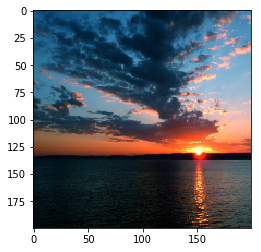

In [56]:
img_path = '../test_images/0.jpg'
img = image.load_img(img_path, target_size=(200, 200))
plt.imshow(img)
plt.show()

In [57]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = model.predict(x)

In [58]:
predicts = classif_rkl.predict(features.reshape(features.shape[0], 2048))
print(predicts)

[[0. 0. 1. 1. 0.]]


In [59]:
class_labels = ['desert', 'mounts', 'sea', 'sunset', 'trees']
[class_labels[i] for i in range(len(class_labels)) if predicts[0][i] == 1]

['sea', 'sunset']